In [61]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import pandas as pd
import os
import polars as pl
import toml
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick
from scipy import stats
import toml

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.transform import Rotation as R

from datetime import datetime as dt

pio.renderers.default = "vscode"
from ultralytics import YOLO

In [62]:
_pth = toml.load("DATA_PATH.toml")["data_path"]["directory"]
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth, "recorded_data", _parent_folder)
_folder_name = "armbo_coordinate_dynamic_t0"

_webcam_calib_folder = os.path.join(
    _pth, "recorded_data", _parent_folder, _calib_folder_name
)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(
    _webcam_calib_folder, "armbo_coordinate_dynamic_rotmat0.msgpack"
)
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

## Mocap data

In [63]:
m1 = get_rb_marker_name(1)
m2 = get_rb_marker_name(2)
m3 = get_rb_marker_name(3)
m4 = get_rb_marker_name(4)

In [64]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [65]:
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_p2_60e_noise.pt')
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_ar_200e_noise_v2.pt')
model_pth = os.path.join(os.getcwd(), "..", "models_save", "mip_ar_200e_noise.pt")
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'best.pt')
yolo_model = YOLO(model_pth)
# model_pth

marker_size = 0.05

marker_points = np.array(
    [
        [-marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, -marker_size / 2, 0],
        [-marker_size / 2, -marker_size / 2, 0],
    ],
    dtype=np.float32,
)

In [66]:
_teensy_df = pl.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_teensy_df = _teensy_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)
t_time = _teensy_df["rust_time"].to_numpy()
t_time = [dt.fromtimestamp(t) for t in t_time]
# t_time = [dt.strftime(t) for t in t_time]
teensy_df = pl.DataFrame({"time": t_time, "sync": _teensy_df["sync"]})
idx = None
for idx, i in enumerate(teensy_df["sync"]):
    if i == 1:
        break
teensy_start_time = teensy_df["time"][idx]

# Aruco parameters

ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [67]:
# TODO: it dosen't work for case where we have repeated marker value + 1 adidtional marker detection

_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data_yolo = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}

counter = 0
NO_DETECTION = False

for _frame in tqdm(_video_data):
    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    ids = []
    # YOLO
    modelcorners = []
    yolo_results = yolo_model.predict(_frame, verbose=False, conf=0.8, half=True)[0]
    _mid, counts = np.unique(yolo_results.boxes.cls.cpu(), return_counts=True)
    # break
    if counts.size == 0:
        NO_DETECTION = True
    elif max(counts) > 1 and _mid.size == 1:
        _max_conf = np.argmax(yolo_results.boxes.conf.cpu())
        for _keys in yolo_results[_max_conf].keypoints.data:
            modelcorners.append(_keys[0:4].cpu().numpy())
    else:
        for _keys in yolo_results.keypoints.data:
            modelcorners.append(_keys[0:4].cpu().numpy())
        modelcorners = np.array(modelcorners)

    if not NO_DETECTION:  # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()

        if max(counts) > 1:
            match _mid:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
            ids = np.array(ids, dtype=np.int32)

        else:
            for i in _idx:
                match i:
                    case 0:
                        ids.append([12])
                    case 1:
                        ids.append([88])
                    case 2:
                        ids.append([89])
            ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0:  # if there are any detections else skip
        try:
            y_rvec, y_tvec = estimatePoseSingleMarkers(
                modelcorners, 0.05, _webcam_cam_mat, _webcam_dist
            )
        except:
            ids = None

    if ids is None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(None)
        data_yolo["corners"].append(None)
        data_yolo["tvec"].append(None)
        data_yolo["rvec"].append(None)

    if ids is not None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(ids)
        data_yolo["corners"].append(modelcorners)
        data_yolo["tvec"].append(y_tvec)
        data_yolo["rvec"].append(y_rvec)
    counter += 1
    NO_DETECTION = False
_video_file.close()

0it [00:00, ?it/s]

964it [00:15, 62.14it/s]


In [68]:
data = data_yolo
coordinate = {
    str(default_ids[0]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[1]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[2]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        _zero_counter = 0
        for j, _m in enumerate(data["marker_ids"][i]):
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)

    doesnt_exist.clear()

## Getting sync and trigger

In [69]:
ar_df_12 = pl.DataFrame(coordinate["12"])
_tts = pl.DataFrame(ts).rename({"column_0": "time", "column_1": "_sync"})
_sync = _tts["_sync"].to_numpy()
for i in range(len(_sync)):
    if _sync[i] == "NA":
        _sync[i] = np.nan
    else:
        _sync[i] = int(_sync[i])

_tts.insert_column(1, pl.Series("sync", np.array(_sync, dtype=np.float32)))
ar_df_12.insert_column(0, _tts["time"])
ar_df_12.insert_column(1, _tts["sync"])
ar_df_12 = ar_df_12.with_columns((pl.col("sync") / pl.col("sync")).alias("trigger"))

ar_df_88 = pl.DataFrame(coordinate["88"])
ar_df_89 = pl.DataFrame(coordinate["89"])
_

Text(446.72727272727263, 0.5, 'Error in cm')

## Reading mocap

In [70]:
_mocap_pth = os.path.join(
    os.path.dirname(os.path.dirname(_video_pth)),
    _folder_name.split("_")[0],
    f"{_folder_name}.csv",
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)
_mocap_pth

cumulative = (
    _mocap_df[[m1["x"], m1["y"], m1["z"]]].to_numpy().T
    + _mocap_df[[m2["x"], m2["y"], m2["z"]]].to_numpy().T
    + _mocap_df[[m3["x"], m3["y"], m3["z"]]].to_numpy().T
    + _mocap_df[[m4["x"], m4["y"], m4["z"]]].to_numpy().T
)
cumulative = cumulative / 4

_m_df = pl.DataFrame(
    {
        "time": _mocap_df["time"],
        "x": cumulative[0],
        "y": cumulative[1],
        "z": cumulative[2],
    }
)

In [71]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean() / 1000
dt = 0.007
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size].mean()
_mean_gy = _imu_df["gy"][:filter_size].mean()
_mean_gz = _imu_df["gz"][:filter_size].mean()
_mean_ax = _imu_df["ax"][:filter_size].mean()
_mean_ay = _imu_df["ay"][:filter_size].mean()
_mean_az = _imu_df["az"][:filter_size].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx") - _mean_gx).alias("gx"),
        (pl.col("gy") - _mean_gy).alias("gy"),
        (pl.col("gz") - _mean_gz).alias("gz"),
    ]
)

# subtracting mean from accel
_imu_df = _imu_df.with_columns(
    [
        (pl.col("ax") - _mean_ax).alias("ax"),
        (pl.col("ay") - _mean_ay).alias("ay"),
        (pl.col("az") - _mean_az).alias("az"),
    ]
)

# apply savgol filter
_imu_df = _imu_df.with_columns(
    [
        pl.col("ax")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("ay")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("az")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
    ]
)

_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx").cum_sum() * dt * 9.81).alias("ang_x"),
        (pl.col("gy").cum_sum() * dt * 9.81).alias("ang_y"),
        (pl.col("gz").cum_sum() * dt * 9.81).alias("ang_z"),
    ]
)

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(
    pl.col("time")
    .map_batches(lambda x: x + timedelta(seconds=timeoffset))
    .alias("time")
)

# change string to float
_imu_df = _imu_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)

In [72]:
rb_angle_df = (
    _mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]]
    .fill_null(np.nan)
    .to_numpy()
)
rb_angle = []
for i in range(len(rb_angle_df)):
    try:
        r = R.from_quat(rb_angle_df[i])
        rb_angle.append(r.as_euler("ZYX", degrees=True))
    except:
        rb_angle.append([np.nan, np.nan, np.nan])
rb_angle = np.array(rb_angle)

In [73]:
_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("sys_time"))
if not (type(ar_df_12["time"][0])) == type(datetime.now()):
    ar_df_12 = ar_df_12.with_columns(
        [
            pl.Series(
                name="time",
                values=[datetime.fromtimestamp(i) for i in ar_df_12["time"].to_numpy()],
            ).alias("time")
        ]
    )

"""Transformation"""
new_ar = {"x": [], "y": [], "z": []}
for i in range(len(ar_df_12)):
    val = (_ar_lframe_rot.T @ ar_df_12[["x", "y", "z"]][i].to_numpy().T).T[0]
    new_ar["x"].append(val[0])
    new_ar["y"].append(val[1])
    new_ar["z"].append(val[2])

In [74]:
_time_offset = _mocap_df["time"][0] - teensy_start_time

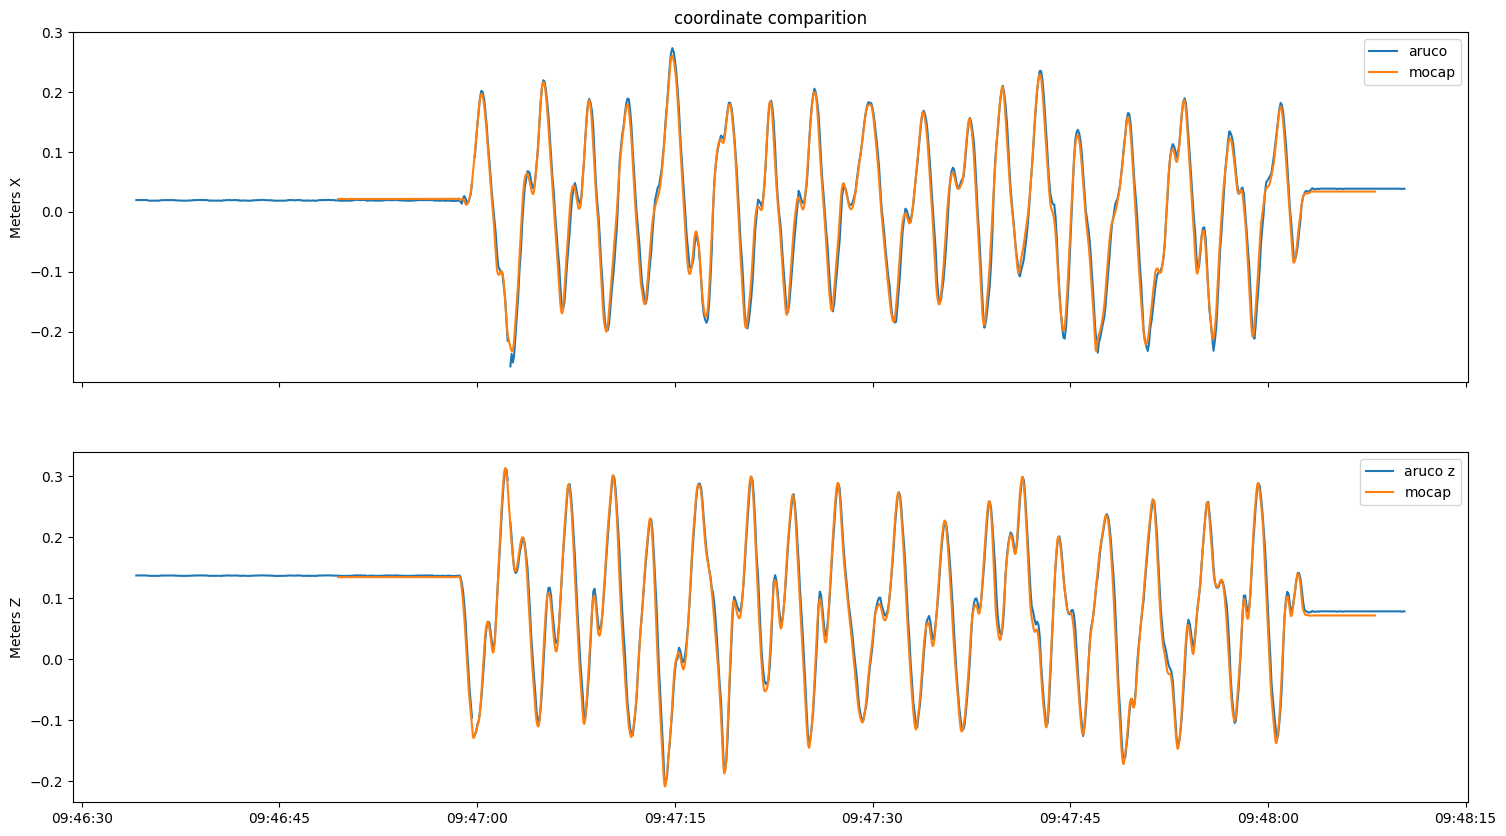

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 10))

axs[0].plot(
    ar_df_12["time"] + _time_offset, np.array(new_ar["x"]) + 0.34, label="aruco"
)
axs[0].plot(_mocap_df["time"], _m_df["x"], label="mocap")
axs[0].legend()
axs[0].set_ylabel("Meters X")
axs[0].set_title("coordinate comparition")

axs[1].plot(
    ar_df_12["time"] + _time_offset, np.array(new_ar["z"]) + 0.35, label="aruco z"
)
axs[1].plot(_mocap_df["time"], _m_df["z"], label="mocap")
axs[1].legend()
axs[1].set_ylabel("Meters Z")
plt.show()

## Trajectory

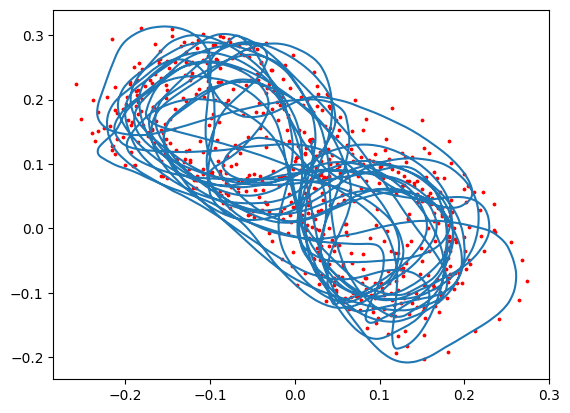

In [86]:
plt.scatter(np.array(new_ar["x"]) + 0.34, np.array(new_ar["z"]) + 0.35, s=3, color="r")
plt.plot(_m_df["x"], _m_df["z"])

In [76]:
temp_x = np.array(new_ar["x"]) + (_m_df["x"][0] - new_ar["x"][0])
temp_z = np.array(new_ar["z"]) + (_m_df["z"][0] - new_ar["z"][0])

f_x = interp1d(
    (_mocap_df["time"] + timedelta(seconds=0)).dt.epoch(),
    _m_df["x"],
    fill_value="extrapolate",
    kind="linear",
)
f_z = interp1d(
    (_mocap_df["time"] + timedelta(seconds=0)).dt.epoch(),
    _m_df["z"],
    fill_value="extrapolate",
    kind="linear",
)
mocap_x = f_x(ar_df_12["time"].dt.epoch() + _time_offset)
mocap_z = f_z(ar_df_12["time"].dt.epoch() + _time_offset)

_diff_x = abs(temp_x - mocap_x) * 100
_diff_z = abs(temp_z - mocap_z) * 100

Text(0, 0.5, 'Error in cm')

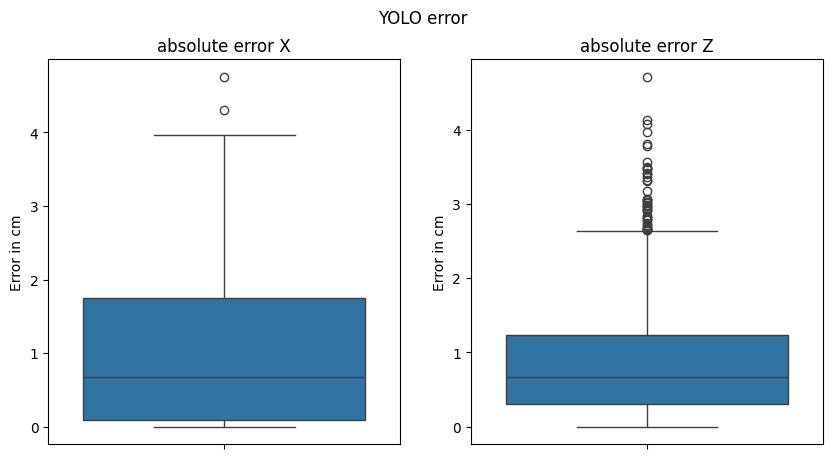

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 5)
fig.suptitle("YOLO error")
sns.boxplot(_diff_x, ax=axs[0])
axs[0].title.set_text("absolute error X")
axs[0].set_ylabel("Error in cm")

sns.boxplot(_diff_z, ax=axs[1])
axs[1].title.set_text("absolute error Z")
axs[1].set_ylabel("Error in cm")